# Adaptive Voter Model Simulation

A short tutorial on using the adaptive voter simulation package.

We start by importing the ```AdaptiveVoter``` class from the package. 
This is the only class we need for the simulation and almost all the code for running the simulation is contained within this one class.

In [1]:
%pylab inline

from adaptive import AdaptiveVoter

import networkx as nx
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Creating a Simulation From Scratch

To build a new simulation, we need to specify the parameters of the model.
These are:
* kap: The preferred degree of the nodes.
* r: The probability of an node update (otherwise an edge update occurs).
* h: Homophily parameter. +1 for complete homophily, -1 for heterophily.
* T: Temperature. Controls how likely a node will change state randomly.
* f: Fraction of neighbourhood required for node state change.

In [2]:
sim = AdaptiveVoter(kap=10,
                    r=0,
                    h=0, 
                    T=0, 
                    f=0)

We then need to set the initial graph structure. 
We can do this by building a graph using NetworkX and then adding this to the simulation using ```.set_initial_network()```.

In [3]:
G = nx.erdos_renyi_graph(40, 0.05)

sim.set_initial_network(G)

We also need to set the initial condition of the node opinions (which are either -1 or +1).
We can specify these states using a vector of opinions, or omit any parameter for a random initial state.

In [4]:
# Prescribed initial condition
sim.set_inital_condition(np.ones(len(G)))

# Random initial condition
sim.set_inital_condition()

To run a single iteration of the simulation we call ```.run_iteration()```.
Currently this does not guarantee that any event (state change) will occur.

In [5]:
sim.run_iteration()

More likely, we will want to run many iterations at once.
We can do this simply by calling ```.run(iterations)```.

In [6]:
sim.run(iterations=1000)

### Querying the Simulation

To query the simulation at any given point we can access the simulation variables.

The opinion vector is stored as ```S```.

In [7]:
sim.S

array([-1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
        1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,
        1, -1,  1, -1, -1,  1])

The node degrees are stored as ```K```, and the adjacency matrix is stored as ```A```.

In [8]:
sim.K

array([12., 11.,  8., 10., 10., 12., 10., 10.,  6., 11.,  9., 12., 10.,
       10., 10., 12., 11., 10., 12., 11., 11., 11., 10., 12., 11., 13.,
        8., 11., 11., 11.,  9., 10., 11.,  8., 11., 10., 10., 10., 11.,
       10.])

The excess degree is stored as ```X```.

In [9]:
sim.X

array([-2., -5., -6., -4.,  2., -2., -6., -4., -2.,  7., -3.,  0.,  0.,
       -2., -2., -4., -5., -0., -2.,  1.,  1.,  3.,  6.,  2.,  1., -5.,
        2.,  1.,  1., -5.,  1., -2., -3.,  2.,  5.,  0.,  4.,  0., -5.,
        6.])

### Queries at different points in time.

There may be instances where we want to query what the system state was at a particular time.
We can move the simulation to a particular point in time by using the ```.build``` function.

In [21]:
sim.build(500)

True

Since our simulation is 1001 iterations in, and we have moved the simulation back to $t=500$, we cannot run further iterations, as shown below.

In [22]:
sim.run_iteration()

Exception: Current view of simulation (pointer=500) is behind final state (t=1001). Move pointer forward to proceed.

We first need to build the simulation back to the latest timepoint so that we can progress the simulation further.
This can be achived by specifying the final time, or using 'max'.

In [23]:
sim.build('max')

True

In [24]:
sim.run_iteration()

### Plotting

We can return the graph of the current state using ```.to_graph()```.
This returns a NetworkX graph where the nodes have an 'opinion' attribute which can be used to change the node colour.

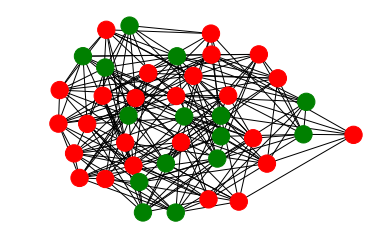

In [10]:
G = sim.to_graph()

# Plotting will be incorporated into the package in the future.
nodes = G.nodes()
cmap = {-1:'r', 1:'g'}
node_colors = [cmap[val] for key,val in nx.get_node_attributes(G,'opinion').items()]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, node_color=node_colors, pos=pos)
nx.draw_networkx_edges(G, pos=pos)
plt.axis('off');

### Saving and Loading

Saving a simulation is simple.
Simulations are saved as JSON files, and can be compressed to save space.

In [11]:
sim.save_to_file('./test.json', compressed=True)

Loading a simulation is through the ```from_saved_simulation``` classmethod.
In this case all that needs to be specified is a path to a valid AdaptiveVoter simulation.

**Note**: To continue running the simulation it first needs to be built.

In [12]:
sim = AdaptiveVoter.from_saved_simulation(filepath='./test.json.gz')

### Simulation Statistics

What we ultimately want from the simulation is to track the evolution of certain attributes of the system.
We can do this using the ```process_timeseries``` function.
There are also some basic functions included in the package (they can mostly fit on one line) to illustrate the possiblities.

In [13]:
from adaptive import process_timeseries, mean_opinion, mean_degree, degree, active_links

The ```process_timeseries``` function takes a simulation object, a time range for which we want to query, and a list of functions that we want to call at each point in time.
In this example, we have taken the mean opinion and degree, as well as the number of active links and the degree vector (should we want to examine the *distribution* of degree over time).

In [14]:
result = process_timeseries(sim, np.linspace(0,1000,40), [mean_opinion, mean_degree, degree, active_links])

The result is a dictionary with a timeseries (also saved as a dictionary) for each function we call.
We can plot the results below (alternatively one might convert to a Pandas Series or DataFrame for convenience).

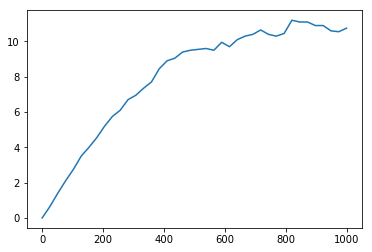

In [15]:
mdegree = result['mean_degree']
plt.plot(list(mdegree.keys()), list(mdegree.values()));

We can create our own statistic to measure over time by creating a custom function.
The only requirements for the function is that it takes a single paramter (the simulation), and makes valid calls to the simulation object.

Below we create a clustering coefficient function and track its value over time.

In [28]:
def clustering(simulation):
    """Calculates the clustering coefficient of a simulation."""
    A = simulation.A
    A2 = A.dot(A)
    A3 = A2.dot(A)
    
    num = np.trace(A3)
    den = (np.sum(A2)-np.trace(A2))
    if num == 0: 
        return 0
    return num / den

result = process_timeseries(sim, np.linspace(0,1000,40), [clustering])

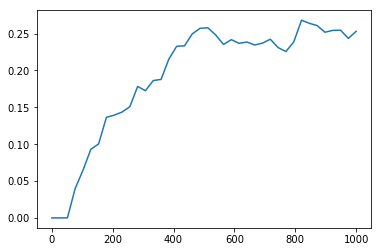

In [29]:
clust = result['clustering']
plt.plot(list(clust.keys()), list(clust.values()));